In [2]:
import csv
import pandas as pd
# 打開CSV文件以讀取
df = pd.read_csv('train_official/train.csv')# 讀取官方提供的訓練資料
print(df)

                   ID  Label
0     train_00000.png      0
1     train_00001.png      1
2     train_00002.png      1
3     train_00003.png      5
4     train_00004.png      5
...               ...    ...
2523  train_02523.png      0
2524  train_02524.png      0
2525  train_02525.png      3
2526  train_02526.png      0
2527  train_02527.png      5

[2528 rows x 2 columns]


In [3]:
#標記標籤
import os
import shutil
path = "train_official/train_images"

images = os.listdir(path)

for i in range(len(images)):
    label = str(df.at[i, "Label"])
    
    images_name = images[i]
    
    source = path + '/' + images_name
    target = "train/" + label + '/' + images_name
    
    shutil.copy(source, target)
    

In [4]:
#讀取資料
import torch
from torchvision import transforms,datasets
import numpy as np
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

transform = transforms.Compose([transforms.Resize(256),
                               transforms.ToTensor()])

data = datasets.ImageFolder("train", transform = transform)


indices = list(range(len(data)))
np.random.shuffle(indices)

#train : validation : test = 8:1:1

train_indices = indices[:int(np.floor(0.8 * len(data)))]
validation_indices = indices[int(np.floor(0.8 * len(data))) : int(np.floor(0.9 * len(data)))]
test_indices = indices[int(np.floor(0.9 * len(data))):]

print(train_indices)
print(validation_indices)
print(test_indices)

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(validation_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 16

train_data = DataLoader(data, batch_size = batch_size, sampler = train_sampler)
validation_data = DataLoader(data, batch_size = batch_size, sampler = validation_sampler)
test_data = DataLoader(data, batch_size = batch_size, sampler = test_sampler)

[2330, 163, 1603, 2321, 1509, 1712, 1652, 863, 1398, 1237, 2300, 286, 1828, 1776, 2184, 221, 1410, 1453, 525, 678, 1739, 2405, 1732, 1507, 2504, 2379, 1048, 1197, 1599, 1926, 1941, 206, 39, 1180, 910, 745, 2398, 786, 2312, 2217, 285, 1266, 2055, 1047, 1340, 474, 1571, 654, 2307, 2160, 1536, 1037, 1836, 973, 1443, 653, 1769, 1678, 759, 859, 1177, 2382, 1494, 2276, 1419, 217, 2510, 2122, 241, 1205, 2470, 2152, 1968, 1606, 2390, 1792, 1102, 1363, 237, 201, 1282, 1051, 1703, 2471, 2480, 2258, 2033, 1498, 1646, 1679, 1714, 1887, 1556, 891, 272, 118, 31, 1372, 136, 1019, 758, 1743, 20, 1904, 284, 2150, 1814, 1669, 2347, 456, 633, 2238, 603, 1359, 2068, 381, 197, 2515, 213, 1835, 858, 2212, 969, 809, 1260, 748, 253, 82, 2278, 1973, 119, 630, 485, 2069, 73, 323, 299, 1474, 1334, 788, 1149, 1082, 1441, 1263, 442, 2136, 1123, 1104, 84, 1558, 625, 101, 202, 919, 8, 581, 1255, 2416, 1135, 958, 1876, 34, 719, 365, 2030, 1145, 2071, 2407, 2247, 43, 1382, 801, 874, 461, 264, 1600, 1007, 1689, 1201, 6

In [5]:
#確認資料形狀
for batch in train_data:
    print(batch[0].shape)
    break

torch.Size([16, 3, 256, 256])


In [6]:
#模型建構
from torch import nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()#這個很重要
        self.conv1 = nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 0)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 0)
        
        self.conv5 = nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 0)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size = 3, stride = 1, padding = 0)
        self.drop = nn.Dropout(0.1)
        
        self.linear1 = nn.Linear(1024 * 14 * 14, 1000)
        self.linear2 = nn.Linear(1000, 6)
        
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.drop(x)
        x = x.view(-1, 1024 * 14 * 14)# make sure input tensor is flattened
        
        x = F.relu(self.linear1(x))
        x = self.drop(x)
        x = F.log_softmax(self.linear2(x), dim = 1)
        
        
        return x

In [7]:
from torch import optim

model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(lr = 0.001, params = model.parameters())

use_gpu = torch.cuda.is_available

if (use_gpu):
    model = model.cuda()
    criterion = criterion.cuda()
    print("gpu")

gpu


In [8]:
for data, label in train_data:
    print(type(data))
    break

<class 'torch.Tensor'>


In [5]:
epoch = 40

min_val_loss = 1e9



for i in range(epoch):
    
    model.train()
    
    train_loss = 0
    for data, label in train_data:
        if (use_gpu):
            data = data.cuda()
            label = label.cuda()
        
        prediction = model(data)
        loss = criterion(prediction, label)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss = train_loss / len(train_data)
    
    val_loss = 0
    
    model.eval()
    with torch.no_grad():
        for data, label in validation_data:
            if (use_gpu):
                data = data.cuda()
                label = label.cuda()

            prediction = model(data)
            loss = criterion(prediction, label)
            val_loss += loss.item()
            
    
        val_loss = val_loss / len(validation_data)
    
    print("epoch", i + 1)
    print("train_loss: ", train_loss)
    print("val_loss: ", val_loss)
    if (val_loss < min_val_loss):
        min_val_loss = val_loss
        torch.save(model.state_dict() ,"checkpoint.pth" )
        print(val_loss , " < ",min_val_loss," save model")
    
    

epoch 1
train_loss:  1.6970369182233735
val_loss:  1.3435009941458702
1.3435009941458702  <  1.3435009941458702  save model
epoch 2
train_loss:  1.0271431878795774
val_loss:  0.7526979595422745
0.7526979595422745  <  0.7526979595422745  save model
epoch 3
train_loss:  0.6774685230311446
val_loss:  0.6765996366739273
0.6765996366739273  <  0.6765996366739273  save model
epoch 4
train_loss:  0.5068229318369092
val_loss:  0.5572628453373909
0.5572628453373909  <  0.5572628453373909  save model
epoch 5
train_loss:  0.42634863470952344
val_loss:  0.5124346502125263
0.5124346502125263  <  0.5124346502125263  save model
epoch 6
train_loss:  0.44874939920864704
val_loss:  0.5474617183208466
epoch 7
train_loss:  0.38019272875715426
val_loss:  0.3822669987566769
0.3822669987566769  <  0.3822669987566769  save model
epoch 8
train_loss:  0.2717595434358974
val_loss:  0.3406701562926173
0.3406701562926173  <  0.3406701562926173  save model
epoch 9
train_loss:  0.25158791474294007
val_loss:  0.22284

In [6]:
check_point = torch.load("checkpoint.pth")
model = Classifier()#要跟讀取的模型同個結構
model.load_state_dict(check_point)
if (use_gpu):
    model = model.cuda()

In [7]:
acc = 0
test_loss = 0
len_test_data = 0

with torch.no_grad():
    model.eval()
    for data, label in test_data:
        if (use_gpu):
            data = data.cuda()
            label =  label.cuda()
        
        prediction = model(data)
        loss = criterion(prediction, label)
        test_loss += loss

        top_p, top_class = torch.exp(prediction).topk(1, dim = 1)

        
        label = label.view(top_class.shape)
        
        equal = label == top_class
        
        acc += equal.sum()
        
        len_test_data += len(data)

print("test_loss: ", test_loss.item() / len(test_data))
print("test_acc: ", acc.item() / len_test_data)

test_loss:  0.1393587291240692
test_acc:  0.9683794466403162


In [8]:
#讀取需要辨識的資料
transform = transforms.Compose([transforms.Resize(256),
                               transforms.ToTensor()])

data = datasets.ImageFolder("test_data", transform = transform)

test_submit = DataLoader(data)

In [9]:
ans = []
with torch.no_grad():
    model.eval()
    for data, label in test_submit:
        if (use_gpu):
            data = data.cuda()
            label =  label.cuda()
        
        prediction = model(data)

        top_p, top_class = torch.exp(prediction).topk(1, dim = 1)
        
        
        ans.append(int(top_class.item()))
print(ans)

[1, 2, 5, 0, 2, 5, 5, 5, 0, 2, 3, 0, 0, 1, 1, 0, 0, 5, 0, 0, 4, 1, 4, 5, 0, 0, 5, 0, 5, 5, 1, 5, 4, 1, 2, 4, 1, 3, 0, 1, 2, 5, 4, 1, 5, 5, 0, 4, 3, 3, 5, 5, 5, 4, 0, 0, 0, 0, 0, 3, 0, 5, 1, 1, 2, 1, 3, 3, 4, 1, 3, 0, 5, 0, 3, 0, 5, 1, 5, 1, 0, 1, 4, 2, 4, 1, 0, 5, 0, 3, 3, 3, 1, 0, 4, 0, 5, 5, 5, 1, 5, 5, 0, 1, 1, 5, 5, 5, 5, 4, 5, 3, 3, 3, 0, 0, 0, 5, 3, 0, 5, 0, 5, 1, 1, 5, 1, 0, 0, 5, 0, 0, 5, 0, 1, 0, 5, 2, 4, 1, 0, 0, 5, 1, 0, 5, 5, 3, 5, 2, 3, 0, 0, 2, 1, 5, 0, 0, 4, 0, 0, 4, 5, 5, 0, 0, 0, 4, 1, 5, 5, 0, 5, 1, 0, 4, 0, 4, 3, 5, 5, 3, 3, 0, 0, 3, 5, 0, 1, 2, 0, 0, 3, 5, 2, 5, 3, 3, 5, 0, 5, 5, 0, 5, 3, 0, 1, 1, 1, 3, 1, 5, 0, 0, 3, 5, 5, 1, 5, 1, 5, 0, 5, 4, 5, 3, 5, 0, 5, 4, 4, 3, 4, 5, 0, 1, 5, 0, 4, 4, 3, 5, 1, 0, 5, 0, 0, 5, 0, 5, 4, 5, 3, 3, 5, 5, 5, 0, 0, 3, 2, 1, 1, 5, 4, 3, 1, 5, 3, 0, 5, 1, 1, 5, 1, 4, 0, 0, 0, 4, 0, 4, 2, 1, 2, 5, 4, 5, 0, 0, 0, 0, 0, 1, 0, 0, 5, 0, 5, 5, 5, 0, 3, 5, 4, 3, 5, 4, 4, 3, 0, 4, 0, 0, 0, 4, 5, 3, 1, 4, 3, 4, 5, 1, 5, 3, 4, 0, 5, 1, 0, 1, 5, 

In [10]:
import csv

csv_change = []
with open("test_data/test.csv", 'r', newline = '', encoding = "utf-8") as file:
    reader = list(csv.reader(file))
    csv_change.append(reader[0])
    print(len(reader))
    print(len(ans))
    for i in range(0, len(ans)):
        reader[i + 1][1] = ans[i]
        csv_change.append(reader[i + 1])
print(csv_change)

10143
10142
[['ID', 'Label'], ['test_00000.png', 1], ['test_00001.png', 2], ['test_00002.png', 5], ['test_00003.png', 0], ['test_00004.png', 2], ['test_00005.png', 5], ['test_00006.png', 5], ['test_00007.png', 5], ['test_00008.png', 0], ['test_00009.png', 2], ['test_00010.png', 3], ['test_00011.png', 0], ['test_00012.png', 0], ['test_00013.png', 1], ['test_00014.png', 1], ['test_00015.png', 0], ['test_00016.png', 0], ['test_00017.png', 5], ['test_00018.png', 0], ['test_00019.png', 0], ['test_00020.png', 4], ['test_00021.png', 1], ['test_00022.png', 4], ['test_00023.png', 5], ['test_00024.png', 0], ['test_00025.png', 0], ['test_00026.png', 5], ['test_00027.png', 0], ['test_00028.png', 5], ['test_00029.png', 5], ['test_00030.png', 1], ['test_00031.png', 5], ['test_00032.png', 4], ['test_00033.png', 1], ['test_00034.png', 2], ['test_00035.png', 4], ['test_00036.png', 1], ['test_00037.png', 3], ['test_00038.png', 0], ['test_00039.png', 1], ['test_00040.png', 2], ['test_00041.png', 5], ['te

In [11]:
with open('C:/Users/weiso131/weiso_AI_practice/AOI 瑕疵分類/test_data/test.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(csv_change)

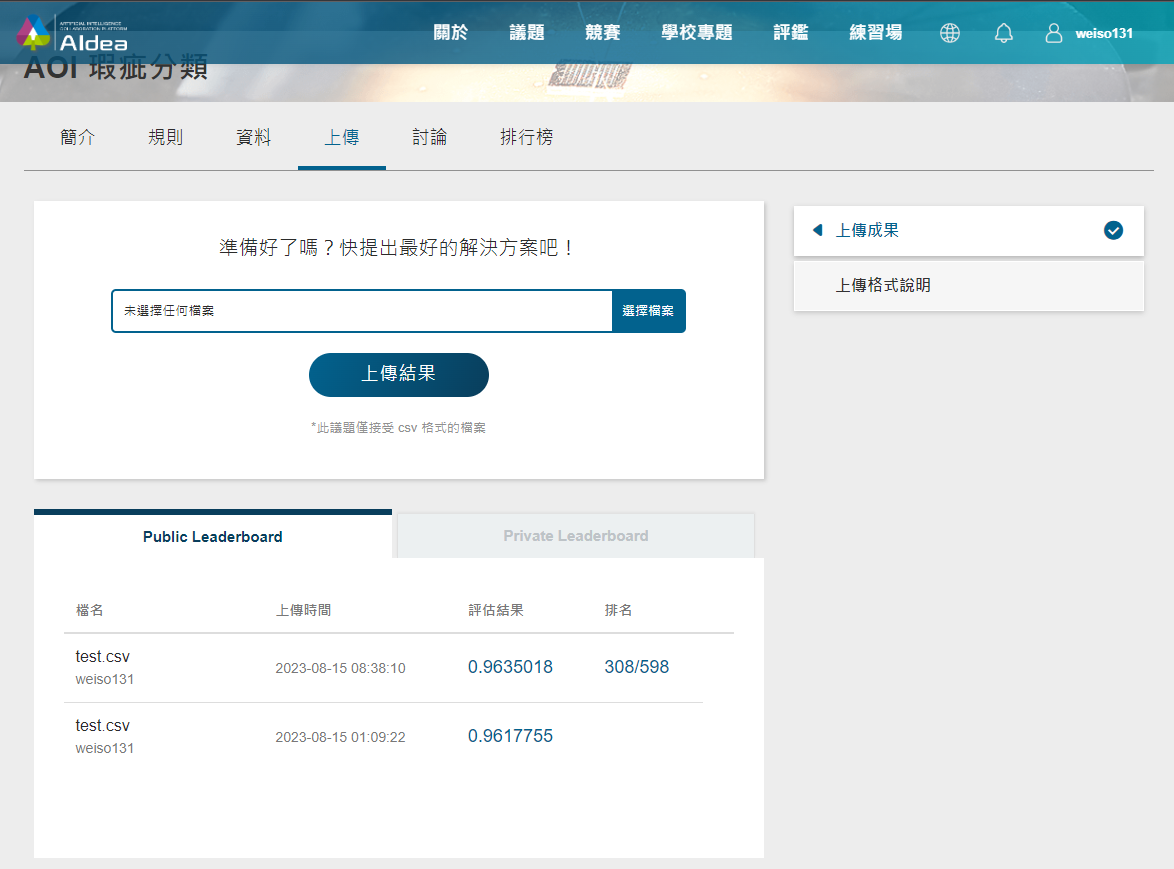